In [63]:
#Importing the necessary packages
import gym 
import tensorflow as tf 
import numpy as np 
import random 
import matplotlib.pyplot as plt

In [64]:
env = gym.make('Assault-v0')
print(env.action_space)
print(env.observation_space)

Discrete(7)
Box(250, 160, 3)


In [65]:
class ExperienceBuffer: 
    
    def __init__(self): 
        self.buffer = []
        self.buffer_capacity = 1000000
        self.current_length = 0
    def write(self, obs): 
        if self.current_length == self.buffer_capacity: 
            self.buffer.pop()
            self.current_length -= 1
        self.buffer.append(obs)
        self.current_length +=1
    def sample_buffer(self, batch_to_sample): 
        return random.sample(self.buffer, min(batch_to_sample, self.current_length))
    def get_capacity(self): 
        return self.current_length

In [66]:
class Network:
    
    def __init__(self, session , n_out):
        self.session = session
        self.n_out = n_out
        # data placeholders
        self.x = tf.placeholder(tf.float32, [None, 4, 200, 100])
        self.tp = tf.transpose(self.x, perm = [0,2,3,1])
        self.y = tf.placeholder(tf.float32, [None, n_out], name='y')
        self.conv_1 = tf.layers.conv2d(self.tp, filters = 32, kernel_size = 8, strides = 4, activation = tf.nn.relu)
        self.conv_2 = tf.layers.conv2d(self.conv_1, filters = 64, kernel_size = 4, strides = 2, activation = tf.nn.relu)
        #self.max_pool_1 = tf.layers.MaxPooling2D(pool_size = 2, strides = 2)
        self.flat_layer = tf.layers.flatten(self.conv_2)
        self.bottleneck_layer = tf.layers.dense(self.flat_layer, 512)
        self.q = tf.layers.dense(self.bottleneck_layer, n_out)
        #COULD BE BUGGY!
        self.loss = tf.reduce_sum(tf.square(self.y - self.q))
        self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.loss)
    def compute(self, input_frames):
        # evaluate the network and return the action values [q(s,a=0),q(s,a=1)]
        return self.session.run(self.q, feed_dict={self.x:input_frames})
    def train(self, x_batch, y_batch): 
            _ = self.session.run(self.train_step, feed_dict={self.x: x_batch, self.y: y_batch})

In [67]:
class ReshapeImage: 
    #Source for data processing: this is also the same as the openAI baseline https://github.com/fg91/Deep-Q-Learning/blob/master/DQN.ipynb
    def __init__(self, target_height = 200, target_width = 100):
        self.target_height = target_height
        self.target_width = target_width
        self.input_rgb_image = tf.placeholder(shape = [4,250,160,3], dtype = tf.uint8)
        self.grayscale_img = tf.image.rgb_to_grayscale(self.input_rgb_image)
        self.bounded_img = tf.image.crop_to_bounding_box(self.grayscale_img, 34, 0, 160, 160)
        self.final_processed = tf.image.resize_images(self.bounded_img, 
                                                [self.target_height, self.target_width], 
                                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    def return_processed_img(self, session, input_img):
        return session.run(self.final_processed, feed_dict = {self.input_rgb_image: input_img})

In [68]:
class Agent: 
    
    def __init__(self, session, policy): 
        #Want a pretty high gamma at first
        self.gamma = 0.99
        #Want pure exploration at first 
        self.epsilon = 1.0
        #want massive adjustments to Q function at first
        self.alpha = 1.0
        #There are six possible outputs
        self.n_out = 7
        #Tune this
        self.batch_size = 32
        self.total_reward = 0
        self.policy = policy
        self.session = session
        self.experience_buffer = ExperienceBuffer()
        self.q = Network(session, self.n_out)
        self.image_reshaper = ReshapeImage()
    def get_action(self, observation): 
        if self.policy == 'DQN':
            if np.random.randn() > self.epsilon: 
                #reshaped_obs = self.image_reshaper.return_processed_img(self.session, observation)
                #need to fix this to feed in 4 stacked frames
               # pos = np.argmax(self.q.compute(reshaped_obs), axis = 1)
                #return pos[0];
                print('use dqn')
                processed_obv = self.image_reshaper.return_processed_img(self.session, observation)
                processed_obv = np.squeeze(processed_obv)
                padded_processed = np.expand_dims(processed_obv, axis = 0)
                action_values = self.q.compute(padded_processed)
                max_action = np.argmax(action_values, axis = 1)
                return max_action[0]
            else: 
                print('chose randomly')
                return random.randint(0,6)
        if self.policy == "dqn_test": 
                #print('use blt in q function')
                processed_obv = self.image_reshaper.return_processed_img(self.session, observation)
                processed_obv = np.squeeze(processed_obv)
                padded_processed = np.expand_dims(processed_obv, axis = 0)
                action_values = self.q.compute(padded_processed)
                max_action = np.argmax(action_values, axis = 1)
                return max_action[0]
    def adjust_epsilon(self, episode_number):
        self.epsilon = 0.01 + (1.0 - 0.01)*np.exp(-.003*episode_number)
    def get_epsilon(self):
        return self.epsilon
    def gather_buffer_exp(self, last_obs, action, reward, obs): 
        processed_obv = self.image_reshaper.return_processed_img(self.session, obs)
        processed_obv = np.squeeze(processed_obv)
        processed_last_obv = self.image_reshaper.return_processed_img(self.session, last_obs)
        processed_last_obv = np.squeeze(processed_last_obv)
        self.experience_buffer.write((processed_last_obv, action, reward, processed_obv))
    def gather_reward(self, reward): 
        self.total_reward += reward
    def get_total_reward(self): 
        return self.total_reward
    def set_reward(self, new_reward): 
        self.total_reward = new_reward
    def return_buffer_size(self): 
        return self.experience_buffer.get_capacity()
    def update_q(self): 
        #PRETTY SURE THIS IS BUSTED BUT FIX LATER!
        self.sars_buffer = self.experience_buffer.sample_buffer(self.batch_size)
        the_x_batch = np.zeros(shape = (np.shape(self.sars_buffer)[0], 4,200,100))
        the_y_batch = np.zeros(shape = (np.shape(self.sars_buffer)[0], self.n_out))
        last_stateq = np.zeros(shape = (np.shape(self.sars_buffer)[0], self.n_out))
        next_q = np.zeros(shape = (np.shape(self.sars_buffer)[0], self.n_out))
        for i in range(np.shape(self.sars_buffer)[0]):
            padded_processed = np.expand_dims(self.sars_buffer[i][0], axis = 0)
            p2 = np.expand_dims(self.sars_buffer[i][3], axis = 0)
            last_stateq[i, :] = self.q.compute(padded_processed)
            next_q[i,:] = self.q.compute(p2)
        for i in range(np.shape(self.sars_buffer)[0]): 
            the_x_batch[i, :] = self.sars_buffer[i][0]
            for j in range(7): 
                if j == self.sars_buffer[i][1]:
                     #action we need to update
                    the_y_batch[i, j] = self.sars_buffer[i][2] + self.gamma * np.max(next_q[i])
                else: 
                     #use the previous q value
                    the_y_batch[i,j] = last_stateq[i,j]
                    
        self.q.train(the_x_batch, the_y_batch)

starting episodes
epsilon1.0
(4, 250, 160, 3)
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


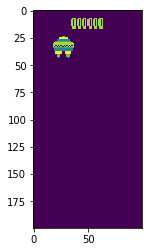

(4, 250, 160, 3)
the reward at stage 0 was 0.0 and the action was 4, during episode 0
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


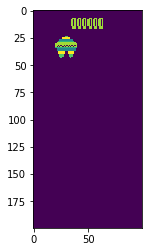

(4, 250, 160, 3)
use dqn
(4, 200, 100, 1)
(4, 200, 100)


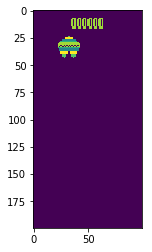

(4, 250, 160, 3)
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


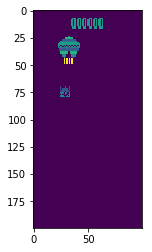

(4, 250, 160, 3)
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


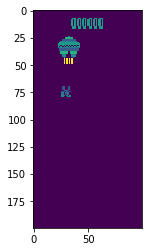

(4, 250, 160, 3)
use dqn
(4, 200, 100, 1)
(4, 200, 100)


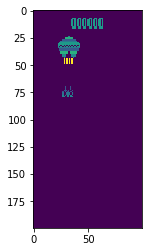

(4, 250, 160, 3)
use dqn
(4, 200, 100, 1)
(4, 200, 100)


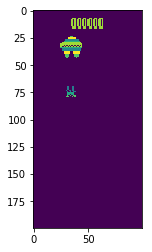

(4, 250, 160, 3)
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


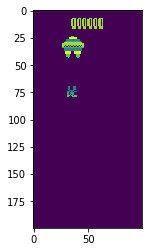

(4, 250, 160, 3)
use dqn
(4, 200, 100, 1)
(4, 200, 100)


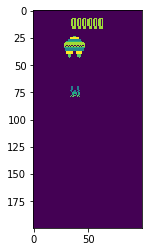

(4, 250, 160, 3)
use dqn
(4, 200, 100, 1)
(4, 200, 100)


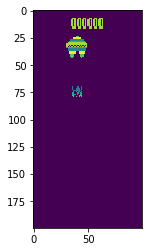

(4, 250, 160, 3)
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


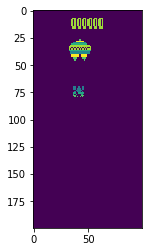

(4, 250, 160, 3)
the reward at stage 10 was 0.0 and the action was 0, during episode 0
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


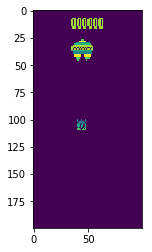

(4, 250, 160, 3)
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


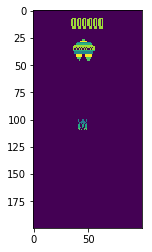

(4, 250, 160, 3)
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


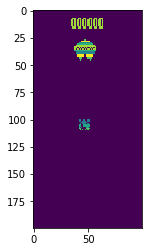

(4, 250, 160, 3)
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


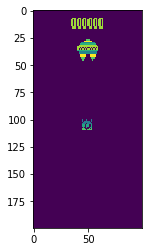

(4, 250, 160, 3)
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


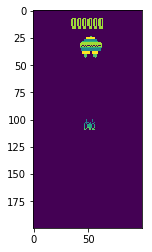

(4, 250, 160, 3)
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


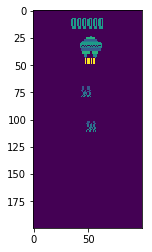

(4, 250, 160, 3)
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


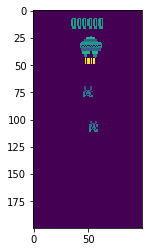

(4, 250, 160, 3)
use dqn
(4, 200, 100, 1)
(4, 200, 100)


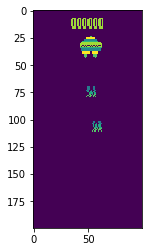

(4, 250, 160, 3)
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


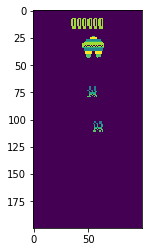

(4, 250, 160, 3)
use dqn
(4, 200, 100, 1)
(4, 200, 100)


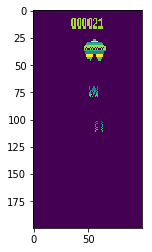

(4, 250, 160, 3)
the reward at stage 20 was 0.0 and the action was 1, during episode 0
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


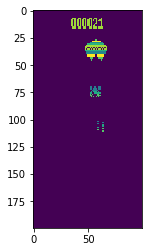

(4, 250, 160, 3)
use dqn
(4, 200, 100, 1)
(4, 200, 100)


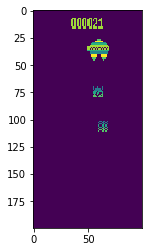

(4, 250, 160, 3)
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


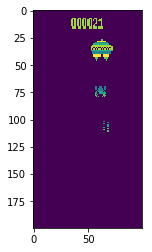

(4, 250, 160, 3)
use dqn
(4, 200, 100, 1)
(4, 200, 100)


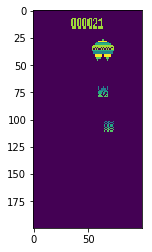

(4, 250, 160, 3)
use dqn
(4, 200, 100, 1)
(4, 200, 100)


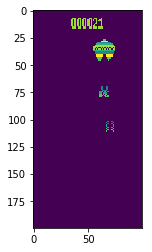

(4, 250, 160, 3)
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


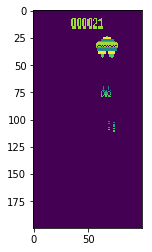

(4, 250, 160, 3)
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


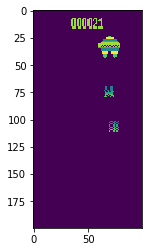

(4, 250, 160, 3)
use dqn
(4, 200, 100, 1)
(4, 200, 100)


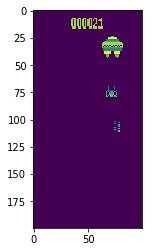

(4, 250, 160, 3)
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


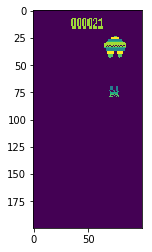

(4, 250, 160, 3)
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


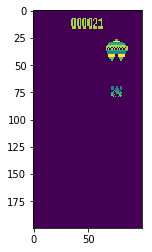

(4, 250, 160, 3)
the reward at stage 30 was 0.0 and the action was 4, during episode 0
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


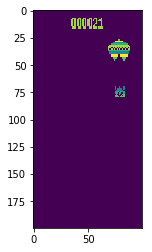

(4, 250, 160, 3)
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


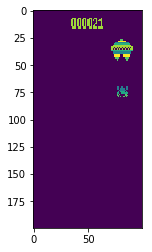

(4, 250, 160, 3)
use dqn
(4, 200, 100, 1)
(4, 200, 100)


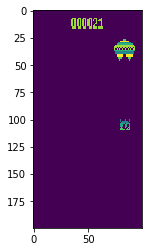

(4, 250, 160, 3)
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


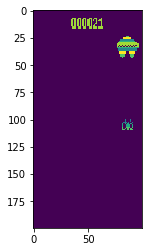

(4, 250, 160, 3)
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


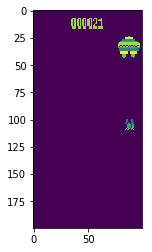

(4, 250, 160, 3)
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


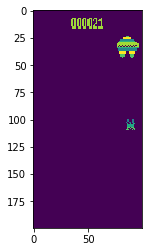

(4, 250, 160, 3)
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


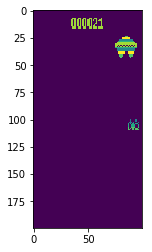

(4, 250, 160, 3)
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


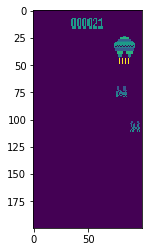

(4, 250, 160, 3)
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


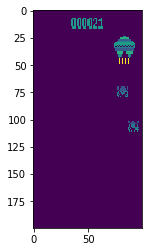

(4, 250, 160, 3)
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


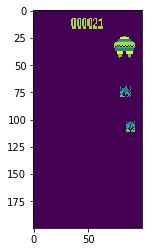

(4, 250, 160, 3)
the reward at stage 40 was 0.0 and the action was 5, during episode 0
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


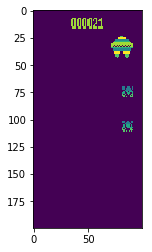

(4, 250, 160, 3)
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


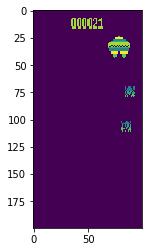

(4, 250, 160, 3)
chose randomly
(4, 200, 100, 1)
(4, 200, 100)


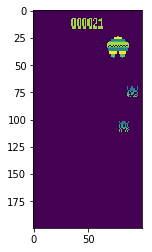

(4, 250, 160, 3)


In [ ]:
#Code to test the actual env:


with tf.Graph().as_default():
    with tf.Session() as session: 
        agent = Agent(session, 'DQN')
        session.run(tf.global_variables_initializer())
        episode_rewards = []
        newshape = ReshapeImage()
        for i_episode in range(800):
            print('starting episodes')
            the_ep = agent.get_epsilon()
            print("epsilon{}".format(the_ep))
            observation = env.reset()
            observation = np.stack([observation,observation,observation,observation], axis = 0)
            print(np.shape(observation))
            agent.set_reward(0)
            for t in range(10000):
                flag = True
                env.render()
                action = agent.get_action(observation)
                new_observation, reward, done, info = env.step(action)
                new_matrix = np.zeros((4,250,160,3))
                new_matrix[0,:,:,:] = observation[1,:,:,:]
                new_matrix[1,:,:,:] = observation[2,:,:,:]
                new_matrix[2,:,:,:] = observation[3,:,:,:]
                new_matrix[3,:,:,:] = new_observation
                new_observation = new_matrix
                #checkout how the image looks
                new_img = newshape.return_processed_img(session,new_observation[:,:,:,:])
                print(np.shape(new_img))
                new_img = np.squeeze(new_img)
                print(np.shape(new_img))
                plt.imshow(new_img[3,:,:])
                plt.show()
                print(np.shape(new_observation))
                
                if done: 
                    new_observation = None
                    flag = False
                if (t % 10 == 0):
                    print("the reward at stage {} was {} and the action was {}, during episode {}".format(t, reward, action,i_episode))
                agent.gather_reward(reward)
                if flag: 
                    agent.gather_buffer_exp(observation, action, reward, new_observation)
                agent.update_q()
                observation = new_observation
                if done:
                    the_ep_reward = agent.get_total_reward()
                    print("Episode {} finished after {} timesteps with total reward {}".format(i_episode, t+1, agent.get_total_reward()))
                    episode_rewards.append(the_ep_reward)
                    print("current buffer size is {}".format(agent.return_buffer_size()))
                    break
            agent.adjust_epsilon(i_episode)
            if(i_episode % 10 == 0):
                plt.plot(episode_rewards)
                plt.show()
       
    
    
    
    #Testing learned function
        
        
        
        
        
        episode_rewards = []
        for (i_ep) in range(51):
            agent.adjust_epsilon(0)
            agent.set_reward(0)
            observation = env.reset()
            observation = np.stack([observation,observation,observation,observation], axis = 0)
            for t in range(10000):
                flag = True
                env.render()
                action = agent.get_action(observation)
                new_observation, reward, done, info = env.step(0)
                new_matrix = np.zeros((4,250,160,3))
                new_matrix[0,:,:,:] = observation[1,:,:,:]
                new_matrix[1,:,:,:] = observation[2,:,:,:]
                new_matrix[2,:,:,:] = observation[3,:,:,:]
                new_matrix[3,:,:,:] = new_observation
                new_observation = new_matrix
                #checkout how the image looks
                #new_img = newshape.return_processed_img(session,new_observation[:,:,:,:])
                #print(np.shape(new_img))
                #new_img = np.squeeze(new_img)
                #print(np.shape(new_img))
                #plt.imshow(new_img[3,:,:])
                #plt.show()
                #print(np.shape(new_observation))
                
                if done: 
                    new_observation = None
                    flag = False
                if (t % 500 == 0):
                    print("the reward at stage {} was {} and the action was {}, during episode {}".format(t, reward, action,i_ep))
                agent.gather_reward(reward)
                #if flag: 
                #    agent.gather_buffer_exp(observation, action, reward, new_observation)
                #agent.update_q()
                observation = new_observation
                if done:
                    the_ep_reward = agent.get_total_reward()
                    print("Episode {} finished after {} timesteps with total reward {}".format(i_ep, t+1, agent.get_total_reward()))
                    episode_rewards.append(the_ep_reward)
                    print("current buffer size is {}".format(agent.return_buffer_size()))
                    break
        if(i_ep % 10 == 0):
                plt.plot(episode_rewards)
                plt.show()
#plt.plot(episode_rewards)
#plt.show()